<a href="https://colab.research.google.com/github/PascalLarouche/Intelligence-artificielle/blob/main/pinn_exemple_keras_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Les réseaux de neurones physiquement informés (PINN) peuvent résoudre des équations différentielles avec ou sans données expérimentales. Ils ont déjà été employées dans de multiples situations et connaissent, depuis leur introduction en 2019, un développement soutenu. Cet exemple a comme objectif de proposer une introduction simple aux PINN. Une première partie met en place la théorie physique de l'oscillateur harmonique sans frottement. Par la suite, les concepts présentés permettront d'illustrer le fonctionnement d'un PINN.

# Théorie : oscillateur harmonique

Un oscillateur harmonique est fabriqué en accrochant un bloc de masse $m$ à l'extrémité d'un ressort dont la constante de rappel est $k$. Pour simplifier, nous allons négliger le frottement. L'équation du mouvement du bloc est construite à partir de la deuxième loi de Newton et de la loi de Hooke.

$$
F = ma \quad et \quad F_{res} = - k x \\
$$

En gardant à l'esprit que l'accélération $a$ est la dérivée seconde $\ddot{x}(t)$ de la position $x(t)$, nous pouvons combiner les deux dernières équations afin de trouver l'équation différentielle décrivant le système masse-ressort :

$$
m \ddot{x} = - k x
$$

L'équation précédente est simplifiée en introduisant la fréquence angulaire $\omega$ :

$$
\ddot{x} = - \frac{k}{m} x = - \omega^{2} x
$$

Cette équation différentielle n'est pas difficile à résoudre exactement. La solution prend la forme suivante où $A$ est l'amplitude et $\phi$ la phase :

$$
x(t) = A cos(\omega t + \phi)
$$

La vitesse de l'oscillateur est obtenue en calculant la dérivée de la position :

$$
v(t) = - A \omega sin(\omega t + \phi)
$$

Les constantes d'intégration $A$ et $\phi$ doivent être déterminées à partir des conditions initiales sur la position $x_{0}$ et la vitesse $v_{0}$. Ainsi, nous avons :

$$
x(t=0) = x_{0} = A cos(\phi)
$$

$$
v(t=0) = v_{0} = -A \omega sin(\phi)
$$

En combinant les précédentes équations, nous obtenons une expression pour $A$ et $\phi$ :

$$
tan(\phi) = - \frac{v_{0}}{\omega x_{0}}
$$

$$
A = \frac{x_{0}}{cos(\phi)}
$$

L'énergie totale $E$ du système masse-ressort est la somme de l'énergie cinétique K et de l'énergie potentielle U :

$$
E = K + U \\
E = \frac{1}{2} m \dot{x}^{2} + \frac{1}{2} k x^{2}
$$

# Théorie : PINN

Les réseaux de neurones physiquement informés (PINN) furent introduits par Raissi et al (2019). Ils reposent sur deux concepts : i) un réseau de neurones sufffisamment complexe peut former une approximation d'une fonction et ii) l'équation différentielle et des conditions initiales peuvent servir à la construction d'une fonction de perte.

Le théorème d'approximation universelle énonce une propriété bien connue des réseaux profonds. Toutefois, comme il s'agit seulement d'une affirmation sur l'existence d'un réseau, a priori, il n'est pas évident de construire le réseau adéquat (et de l'entraîner!) pour un problème donné. Heureusement, dans le cadre d'un PINN, il est aisé de mettre en place le bon réseau. Comme nous le montrerons, quelques couches sont suffisantes pour représenter adéquatement la position de la masse en fonction du temps $x(t)$.

Dans le présent exemple, l'équation différentielle représentant le système masse-ressort est transformée en fonction de perte $L_F$ en regroupant les deux termes du même côté de l'égalité afin que leur somme soit nulle :

$$
L_{F} = \frac{1}{N_{col}} \sum_{i=1}^{N_{col}} [\ddot{x}(t_i) + \omega^2 x(t_i)]^2
$$

Un nombre $N_{col}$ de valeurs distinctes (nommées collocales) de $t$ sont passées dans le réseau pour obtenir autant d'approximations de $x(t)$ et de valeurs de $L_F$. Quant aux conditions initiales, nous avons simplement :

$$
L_B = \frac{1}{N_{col}} \sum_{i=1}^{N_{col}} [x(t_i=0) - x_0)^2 + (\dot{x}(t_i=0) - v_0]^2
$$

Dans l'équation précédente, les quantités $x_0$ et $v_0$ sont des valeurs numériques connues associées à une situation spécfique. Quant à $\dot{x}(t)$, elle est évaluée par différentiation automatique de la sortie du réseau. Finalement, en combinant les deux dernières équations, nous obtenons la perte totale :

$$
L_{totale} = L_F + L_B
$$

Cette construction particulière de la fonction de perte est la seule modification par rapport au réseau de neurones profond de base. L'entraînement d'un PINN suit la procédure habituelle.

In [ ]:
# Importation des modules.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Préparation des données

Diverses constantes doivent être définies. Également, une fonction calculant la solution exacte est définie afin de valider les résultats obtenus plus tard avec le réseau.

In [ ]:
# Constantes physiques
masse = 2
coeff_k = 2.1
omega = np.sqrt(coeff_k / masse)

In [ ]:
# Conditions initiales
x_zero = 1
v_zero = 2

In [ ]:
# Constantes d'intégration
tan_phi = - v_zero / (omega * x_zero)
amp = x_zero / np.cos(np.arctan(tan_phi))
phi = np.arctan(tan_phi)

In [ ]:
# Pour comparer les valeurs calculées par le réseau aux valeurs exactes.
def pos_exacte(temps):
  """
  Fonction qui calcule la position exacte de l'oscillateur harmonique.
  """
  return amp * np.cos(omega * temps + phi)

In [ ]:
# Données collocales
nb_pts_col = 65
temps_init = 0.0
temps_fin = 10
temps_col = np.linspace(temps_init, temps_fin, nb_pts_col)
temps_col = np.expand_dims(temps_col, axis=1)
temps_col = tf.convert_to_tensor(temps_col, dtype=tf.float32)

# Entraînement du réseau

Le problème que nous tentons de résoudre est simple et pour cette raison, la solution peut être trouvées à l'aide d'un réseau de seulement 3 couches cachées de 32 neurones. De manière générale, un réseau trop complexe à tendance à créer des oscillations pendant l'entraînement, retardant le convergence du réseau. Pour les couches cachées, $\tanh$ est la fonction d'activation donnant habituellement les meilleurs résultats ; quand à la couche de sortie, une activation linéaire est obligatoire afin que le réseau puisse fournir en sortie des valeurs supérieures à 1.

In [ ]:
reseau_col = tf.keras.Sequential([

    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(1, activation='linear')

])

reseau_col.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2209 (8.63 KB)
Trainable params: 2209 (8.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Dans la fonction suivante, x_t et x_tt représentent, respectivement, $\dot{x}$ et $\ddot{x}$. perte_eqn retourne, entre autres choses, la perte du réseau calculée à partir de l'équation différentielle et des conditions initiales. Comme il sera démontré à la dernière section, il est intéressant d'enregistrer les valeurs de $\dot{x}$ et $\ddot{x}$ pour analyser les résultats et l'évolution de l'apprentissage.

In [ ]:
def perte_eqn(temps, reseau_neurones):
  """
  Fonction qui évalue la perte de l'équation différentielle et des conditions initiales.

  Args:
    temps : la variable temps pour calculer x(t) et v(t).
    reseau_neurones : le réseau de neurones pour modéliser x(t).

  Retourne:
    Un dictionnaire contenant les valeurs de perte (collocation, conditions initiales et totale), de x(t) et de sa dérivée (la vitesse).
  """
  # Constantes
  tf_zero = tf.constant([[temps_init]], dtype=tf.float32)
  tf_x_zero = tf.constant([[x_zero]], dtype=tf.float32)
  tf_v_zero = tf.constant([[v_zero]], dtype=tf.float32)
  tf_omega = tf.constant([[omega]], dtype=tf.float32)

  # Différentiation automatique.
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(temps)
    x = reseau_neurones(temps)
    x_t = tape.gradient(x, temps)

  # Dérivée seconde de la position = accélération.
  x_tt = tape.gradient(x_t, temps)

  # Évaluer x_t a tf_zero.
  x_t_a_zero = x_t[0]

  # Perte produite par l'équation.
  perte_eqn = tf.reduce_mean(tf.square(x_tt + (tf_omega**2) * x))

  # Perte produite par les conditions initiales.
  perte_x_zero = tf.reduce_mean(tf.square(reseau_neurones(tf_zero) - tf_x_zero))
  perte_v_zero = tf.reduce_mean(tf.square(x_t_a_zero - tf_v_zero))

  return {"pos":x, "vit":x_t, "collocal":perte_eqn, "ci":perte_x_zero + perte_v_zero, "totale":perte_eqn + perte_x_zero + perte_v_zero}

La boucle d'entraînement d'un PINN est très standard et peut être implémentée rapidement avec tf.GradientTape. Notons que des listes sont initialisées afin de recueillir les données à chaque époque. Les résultats sont tous regroupés dans un unique dictionnaire.

In [ ]:
def entrainement_pinn(t, reseau, fct_perte_eqn, optimisateur, nb_epoques):
  """
  Fonction qui lance l'entraînement du réseau de neurones de type PINN.

  Args:
    t : la variable temps pour calculer x(t) et v(t).
    reseau : le réseau de neurones pour modéliser x(t).
    fct_perte_eqn : la fonction qui calcule la perte de l'équation différentielle et des conditions initiales.
    optimisateur : l'optimiseur employé pendant l'entraînement pour la descente en gradient.
    nb_epoques : le nombre d'époques d'entraînement.

  Retourne:
    La solution de l'équation différentielle approximée par le réseau.
    Un dictionnaire contenant les valeurs de perte de l'équation et des conditions initiales en plus de leur somme.
  """
  liste_perte_totale = []
  liste_perte_col = []
  liste_perte_ci = []
  liste_x = []
  liste_v = []

  for i in range(nb_epoques):

    with tf.GradientTape() as tape:

      tape.watch(t)
      info_perte = perte_eqn(t, reseau)

    # Différentiation automatique.
    gradients = tape.gradient(info_perte["totale"], reseau.trainable_variables)
    # Descente en gradient.
    optimisateur.apply_gradients(zip(gradients, reseau.trainable_variables))

    # Enregistrement des pertes dans les listes correspondantes.
    liste_perte_col.append(info_perte["collocal"])
    liste_perte_ci.append(info_perte["ci"])
    liste_perte_totale.append(info_perte["totale"])
    liste_x.append(info_perte["pos"])
    liste_v.append(info_perte["vit"])

    # Impression des données de pertes.
    if i == 0:
      print(f"Époque {i + 1:>4} -> Perte : totale = {liste_perte_totale[-1]:.2e} - collocal = {liste_perte_col[-1]:.2e} - ci = {liste_perte_ci[-1]:.2e}")
    elif (i + 1) % 200 == 0:
      print(f"Époque {i + 1:>4} -> Perte : totale = {liste_perte_totale[-1]:.2e} - collocal = {liste_perte_col[-1]:.2e} - ci = {liste_perte_ci[-1]:.2e}")

  return {"pos":liste_x, "vit":liste_v, "collocal":liste_perte_col, "ci":liste_perte_ci, "totale":liste_perte_totale}

# Entraînement du réseau

Étant donné le nombre relativement faible de données employées pour l'entraînement, un nombre élevé d'époques doit être utilisé.  

In [ ]:
# Adam est également efficace pour entraîner un PINN.
optimizer_data = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
res_pinn = entrainement_pinn(temps_col, reseau_col, perte_eqn, optimizer_data, 3000)

Époque    1 -> Perte : totale = 7.01e+00 - collocal = 2.56e-01 - ci = 6.76e+00
Époque  200 -> Perte : totale = 3.59e-01 - collocal = 3.30e-01 - ci = 2.93e-02
Époque  400 -> Perte : totale = 2.57e-01 - collocal = 2.40e-01 - ci = 1.69e-02
Époque  600 -> Perte : totale = 1.88e-01 - collocal = 1.80e-01 - ci = 8.65e-03
Époque  800 -> Perte : totale = 1.61e-01 - collocal = 1.55e-01 - ci = 5.97e-03
Époque 1000 -> Perte : totale = 1.40e-01 - collocal = 1.35e-01 - ci = 4.55e-03
Époque 1200 -> Perte : totale = 1.12e-01 - collocal = 1.09e-01 - ci = 3.43e-03
Époque 1400 -> Perte : totale = 7.71e-02 - collocal = 7.49e-02 - ci = 2.17e-03
Époque 1600 -> Perte : totale = 3.99e-02 - collocal = 3.90e-02 - ci = 9.63e-04
Époque 1800 -> Perte : totale = 1.66e-02 - collocal = 1.63e-02 - ci = 2.92e-04
Époque 2000 -> Perte : totale = 8.40e-03 - collocal = 8.29e-03 - ci = 1.08e-04
Époque 2200 -> Perte : totale = 5.71e-03 - collocal = 5.64e-03 - ci = 6.94e-05
Époque 2400 -> Perte : totale = 4.22e-03 - collocal 

Étant donné qu'un grand nombre d'époques d'entraînement sont nécessaires, afficher les pertes sur un graphique log-log permet de mieux visualiser les données.

[]

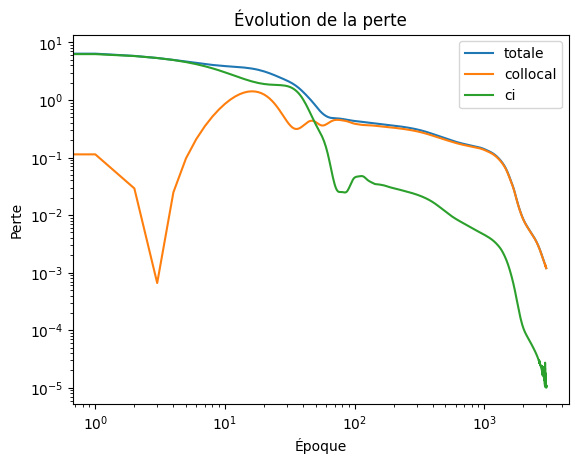

In [ ]:
plt.plot(res_pinn["totale"], label="totale")
plt.plot(res_pinn["collocal"], label="collocal")
plt.plot(res_pinn["ci"], label="ci")
plt.legend()
plt.title("Évolution de la perte")
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.loglog()

Nous pouvons maintenant comparer les résultats prédits aux valeurs exactes.

In [ ]:
data_pred = reseau_col.predict(temps_col)

3/3 [==============================] - 0s 2ms/step


Text(0, 0.5, 'Position')

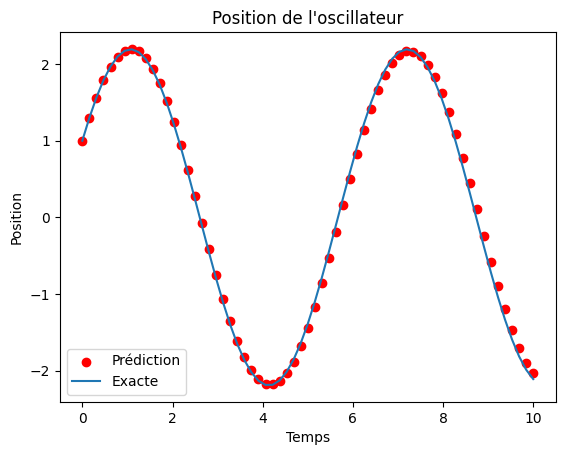

In [ ]:
plt.scatter(temps_col, data_pred, color="red")
plt.plot(temps_col, pos_exacte(temps_col))
plt.legend(["Prédiction", "Exacte"])
plt.title("Position de l'oscillateur")
plt.xlabel("Temps")
plt.ylabel("Position")

# Analyse des résultats

Cette dernière partie met en lumière le processus d'entraînement. Il est particulièrement intéressant d'afficher les approximations successives de la position $x(t)$. Une animation permet de visualiser le tout.

In [ ]:
# Création de liste pour les positions et les vitesses pour chaque époque.
vit = res_pinn["vit"]
pos = res_pinn["pos"]

In [ ]:
# Échantillonnage de 1/100 de courbes enregistrées.
pos_select = pos[::100]

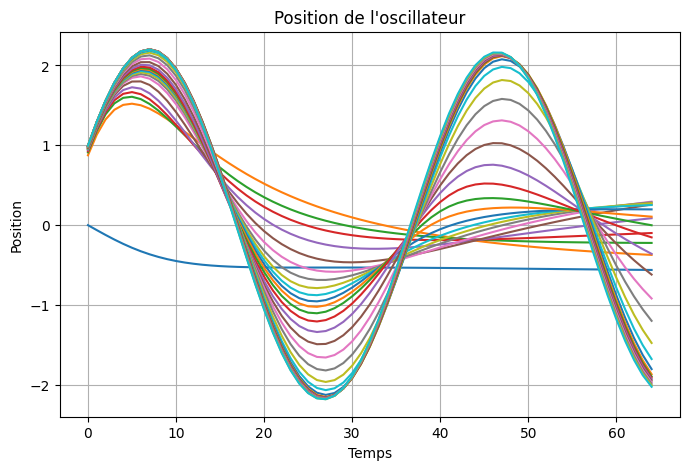

In [ ]:
plt.figure(figsize=(8, 5))
for i, liste in enumerate(pos_select):
    plt.plot(liste, label=f'Liste {i + 1}')
plt.title("Position de l'oscillateur")
plt.xlabel("Temps")
plt.ylabel("Position")
plt.grid()

In [ ]:
def animer_donnees(data, xlabel, ylabel, titre, xmin, xmax, ymin, ymax):
    """
    Fonction pour créer et afficher une animation à partir de données fournies.

    Arguments:
    data : Une liste contenant plusieurs listes de points à animer.
    xlabel : Étiquette pour l'axe des x.
    ylabel : Étiquette pour l'axe des y.
    titre  : Titre du graphique.
    xmin   : Limite inférieure de l'axe des x.
    xmax   : Limite supérieure de l'axe des x.
    ymin   : Limite inférieure de l'axe des y.
    ymax   : Limite supérieure de l'axe des y.
    """

    # Configuration de la figure
    fig, ax = plt.subplots(figsize=(5, 3))
    line, = ax.plot([], [], 'bo-', label='Données')  # Initialisation de la ligne vide
    ax.set_title(titre)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid()

    # Initialiser l'animation
    def init():
        line.set_data([], [])
        return line,

    # Fonction pour mettre à jour le graphique à chaque frame
    def update(frame):
        y_data = data[frame]  # Obtenir la liste correspondante
        x_data = np.arange(len(y_data))  # Indices
        line.set_data(x_data, y_data)  # Mettre à jour les données de la ligne
        return line,

    # Créer l'animation
    ani = FuncAnimation(fig, update, frames=len(data), init_func=init, blit=True, repeat=True)

    # Afficher l'animation dans Google Colab
    return HTML(ani.to_jshtml())  # Retourner l'animation en format JavaScript

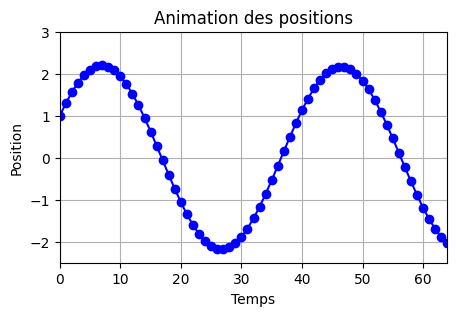

In [ ]:
animation = animer_donnees(pos[::50], "Temps", "Position", "Animation des positions", 0, len(pos_select[0]) - 1, -2.5, 3)
display(animation)

En l'absence de frottement ou de mécanisme de dissipation, l'énergie totale de l'oscillateur est constante. Comme a chaque itération la position et la vitesse de l'oscillateur sont connues, il est possible de calculer l'énergie à chaque étape de l'entraînement. L'animation montre bien qu'après les premières itérations, l'énergie n'est pas conservée. Toutefois, comme il se doit, le réseau parvient à la bonne solution en respectant le principe fondamental de conservation de l'énergie.

In [ ]:
def energie_totale(x, v, masse, k):
  """
  Fonction qui calcule l'énergie totale de l'oscillateur.

  Args:
    x : la position de l'oscillateur.
    v : la vitesse de l'oscillateur.
    masse : la masse de l'oscillateur.
  """

  x = np.array(x)
  v = np.array(v)
  ener = 0.5 * masse * v**2 + 0.5 * k * x**2

  return ener

In [ ]:
ener = energie_totale(pos, vit, masse, coeff_k)

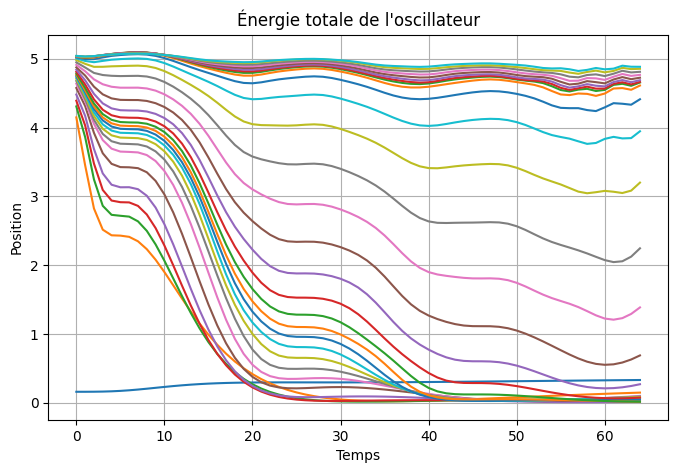

In [ ]:
plt.figure(figsize=(8, 5))
for i, liste in enumerate(ener[::100]):
    plt.plot(liste, label=f'Liste {i + 1}')
plt.title("Énergie totale de l'oscillateur")
plt.xlabel("Temps")
plt.ylabel("Position")
plt.grid()

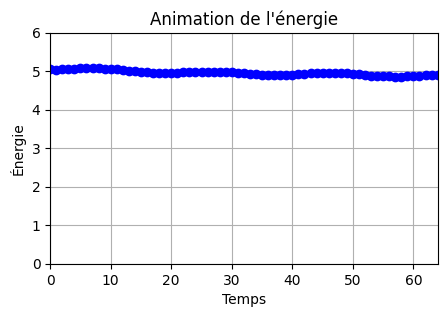

In [ ]:
animation_energie = animer_donnees(ener[::50], "Temps", "Énergie", "Animation de l'énergie", 0, len(pos_select[0]) - 1, 0, 6)
display(animation_energie)

# Conclusion

La simplicité du présent exemple avait pour but de mettre en évidence les propriétés élémentaires des PINN. Ce choix fait en sorte que certaines caractéristiques ont été omises. Par exemple, un coefficient multiplicatif peut être ajouté devant les pertes afin de moduler leur importance et influence le processus d'entraînement. Il également possible d'ajouter à un troisième terme à la fonction de perte en employant des données expérimentales pour calculer une perte entre les prédictions du réseau et les valeurs attendues.